In [1]:
import pandas as pd

In [2]:
PATH = 'data/d.csv'

In [3]:
csv = pd.read_csv(PATH)

In [4]:
csv

,plant.ID,y,alpha
0,1,0,-4.159582
1,2,0,-3.718362
2,3,0,-3.069020
3,4,0,-3.054211
4,5,0,-2.880656
5,6,2,-2.705595
6,7,1,-2.441703
7,8,1,-2.221327
8,9,0,-2.209120
9,10,1,-2.111941


In [5]:
ys = csv['y'].values

In [6]:
import numpy as np

histo_ys = np.zeros(11)
for y in ys:
    histo_ys[y] += 1
print(histo_ys)
print(np.sum(histo_ys))

[  7.  10.  10.   5.  12.  11.  11.   7.  14.   9.   4.]
100.0


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

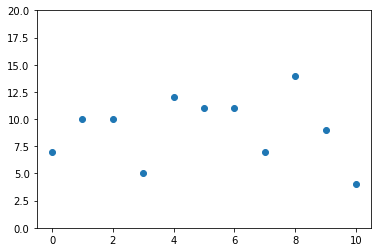

In [8]:
xs = np.arange(11)
plt.scatter(xs, histo_ys)
plt.ylim(0, 20)
plt.show()

In [9]:
import pymc3 as pm

In [10]:
ys

array([ 0,  0,  0,  0,  0,  2,  1,  1,  0,  1,  2,  2,  1,  1,  4,  1,  1,
        1,  1,  2,  4,  2,  2,  6,  2,  3,  0,  3,  6,  5,  2,  4,  1,  5,
        5,  3,  4,  4,  3,  5,  2,  3,  5,  6,  4,  4,  5,  2,  6,  6,  8,
        4,  6,  5,  5,  7,  4,  6,  4,  5,  5,  4,  6,  7,  4,  5,  6, 10,
        9, 10,  8,  7,  8,  6,  8,  8,  8,  9,  9,  8,  9,  7,  8,  7,  7,
        8,  8,  9,  8,  9,  9,  9,  8,  7,  6,  8,  8,  9, 10, 10])

In [11]:
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=ys)
    map_estimate = pm.find_MAP(model=model)

logp = -316.78, ||grad|| = 4: 100%|██████████| 5/5 [00:00<00:00, 1058.42it/s]


In [12]:
print((float(map_estimate['q'])))

0.4960000053023121


In [13]:
import scipy

In [14]:
rv = scipy.stats.binom(10, map_estimate['q'])
binom_ys = [100 * rv.pmf(k) for k in range(11)]

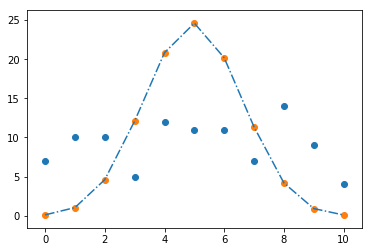

In [15]:
plt.scatter(xs, histo_ys)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.show()

In [16]:
model = pm.Model()
with model:
    beta = pm.Normal('beta', mu=0, tau=1.0e-2)
    tau = pm.Gamma('tau', alpha=1.0e-02, beta=1.0e-02)
    alpha = pm.Normal('alpha', mu=0, tau=tau , shape=len(ys))
    ymu = pm.math.sigmoid(beta + alpha)
    y = pm.Binomial('y', n=10, p=ymu, observed=ys)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(5000, start=start, step=step)
alpha.shape

logp = -48.984, ||grad|| = 0.031497: 100%|██████████| 33/33 [00:00<00:00, 1508.22it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, tau, beta]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:10<00:00, 1037.22draws/s]


Shape.0

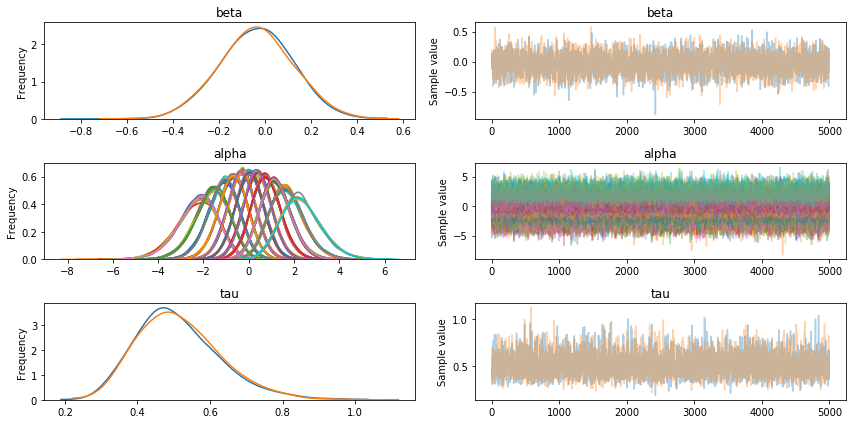

In [17]:
pm.traceplot(trace)
plt.figure(figsize=(10, 20))
plt.show()

In [18]:
beta_samples = trace['beta'][:]
print(beta_samples.shape)
beta_samples = beta_samples.reshape(-1, 1)
print(beta_samples.shape)

(10000,)
(10000, 1)


In [19]:
alpha_samples = trace['alpha'][:]
alpha_samples.shape

(10000, 100)

In [20]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [21]:
q_samples = sigmoid(beta_samples + alpha_samples)
q_samples.shape

(10000, 100)

In [22]:
mean_q = q_samples.mean(axis=0)
print(mean_q.shape)
mean_q


(100,)


array([ 0.11511412,  0.11346187,  0.11523899,  0.11461867,  0.11456335,
        0.25668484,  0.18302829,  0.18080318,  0.1139035 ,  0.18226103,
        0.25715845,  0.25808696,  0.18388199,  0.18194484,  0.41556757,
        0.18376508,  0.18223667,  0.18272406,  0.18331916,  0.2577499 ,
        0.41787456,  0.25672896,  0.25689254,  0.57974929,  0.25734622,
        0.33694074,  0.11624324,  0.33685499,  0.57935031,  0.50066417,
        0.2578937 ,  0.41717603,  0.18242603,  0.50078302,  0.49748902,
        0.33534364,  0.41634253,  0.41427958,  0.33588014,  0.49867155,
        0.25749111,  0.3346409 ,  0.49979362,  0.58021393,  0.41554581,
        0.41794145,  0.49919701,  0.25796754,  0.58302693,  0.58133502,
        0.74044722,  0.41749772,  0.57951785,  0.49881822,  0.49718197,
        0.6610231 ,  0.41488981,  0.57946883,  0.41573302,  0.49837968,
        0.49927103,  0.41829411,  0.58033557,  0.66152832,  0.41482515,
        0.49849094,  0.57854198,  0.88331561,  0.81430814,  0.88

In [23]:
rows, = mean_q.shape
rows

100

In [24]:
# rows, cols = q_samples.shape
# for col in range(cols):  # cols 100
#     print(col)
#     for row in range(rows):  # rows 10000
#         rv = scipy.stats.binom(10, q_samples[row, col])
#         y_samples[i] = [rv.pmf(k) for k in range(11)]
#     y_samples[i] /= rows

In [25]:
y_samples = np.empty((100, 11))
for i in range(rows):
    rv = scipy.stats.binom(10, mean_q[i])
    y_samples[i] = [rv.pmf(k) for k in range(11)]
pred_y = np.sum(y_samples, axis=0)
print(pred_y.shape)

(11,)


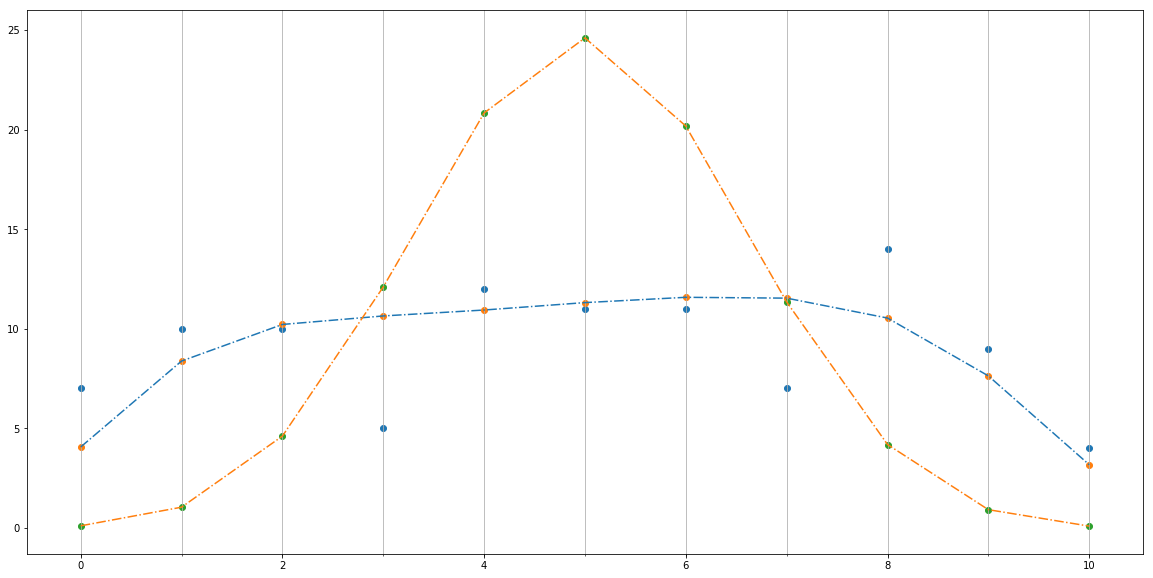

In [26]:
import matplotlib.ticker as tick
plt.figure(figsize=(20,10))
plt.scatter(xs, histo_ys)
plt.plot(xs, pred_y, ls='-.')
plt.scatter(xs, pred_y)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
# plt.legend(loc='best')
plt.show()

In [27]:
std_q = q_samples.std(axis=0)
print(std_q.shape)
std_q

(100,)


array([ 0.08011225,  0.07956149,  0.08047869,  0.08152245,  0.07949882,
        0.11772269,  0.10317092,  0.10160827,  0.08086116,  0.1017023 ,
        0.11791686,  0.11846739,  0.10248742,  0.10011403,  0.13428326,
        0.10320196,  0.10148137,  0.10328275,  0.10331103,  0.11821184,
        0.1341329 ,  0.11694197,  0.1177622 ,  0.13489524,  0.1188654 ,
        0.12871974,  0.08211706,  0.12723574,  0.13838897,  0.13697262,
        0.11778775,  0.13712784,  0.10113906,  0.13857667,  0.13759341,
        0.12932658,  0.13688505,  0.13351676,  0.12793606,  0.14011271,
        0.1170963 ,  0.12988408,  0.13658587,  0.13515036,  0.13794375,
        0.13496849,  0.13833089,  0.11636669,  0.13698267,  0.13478264,
        0.11876943,  0.13566439,  0.13628554,  0.13898447,  0.1380884 ,
        0.13080221,  0.13700089,  0.13570355,  0.13465416,  0.13712122,
        0.13916345,  0.13589191,  0.13441749,  0.12956457,  0.13543262,
        0.13890131,  0.13739762,  0.08096903,  0.10123099,  0.08

In [28]:
yp_samples = np.empty((100, 11))
ym_samples = np.empty((100, 11))
for i in range(rows):
    prv = scipy.stats.binom(10, std_q[i] + mean_q[i])
    yp_samples[i] = [prv.pmf(k) for k in range(11)]
    mrv = scipy.stats.binom(10, -std_q[i] + mean_q[i])
    ym_samples[i] = [mrv.pmf(k) for k in range(11)]

pred_py = np.sum(yp_samples, axis=0)
pred_my = np.sum(ym_samples, axis=0)

print(pred_y.shape)

(11,)


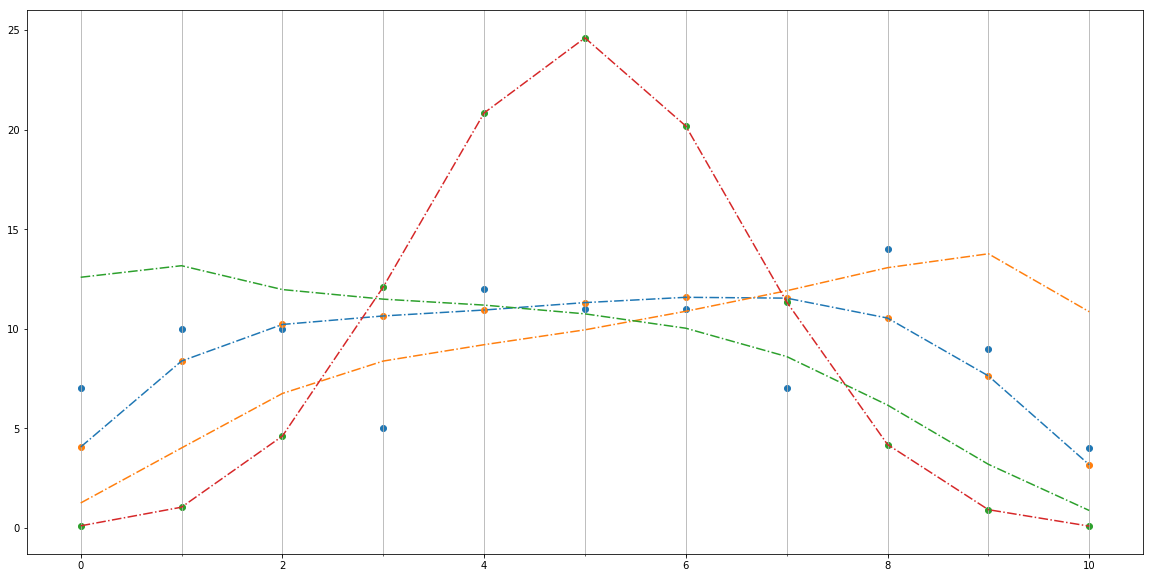

In [29]:
plt.figure(figsize=(20,10))
plt.scatter(xs, histo_ys)
plt.plot(xs, pred_y, ls='-.')
plt.plot(xs, pred_py, ls='-.')
plt.plot(xs, pred_my, ls='-.')
plt.scatter(xs, pred_y)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
# plt.legend(loc='best')
plt.show()